```
RoPE의 세타(θ) 값에 따른 성능 비교
```
- seq_len에 비례해 세타를 조정

In [1]:
## Importing Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 128
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('./input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 64])
Target shape: torch.Size([512, 64])
Sample 1: ------------------------------
Input sequence : o to, sir; you weigh equally; a feather will turnthe scale.PO
Target sequence:  to, sir; you weigh equally; a feather will turnthe scale.POM

Sample 2: ------------------------------
Input sequence : ngham,--BUCKINGHAM:What, my gracious lord?PRINCE EDWARD:An
Target sequence: gham,--BUCKINGHAM:What, my gracious lord?PRINCE EDWARD:An 

Sample 3: ------------------------------
Input sequence : r, now looks he like a king!Ay, this is he that took King Henry
Target sequence: , now looks he like a king!Ay, this is he that took King Henry'



## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def ___generate(model, char_to_idx, idx_to_char, start_char, max_length, device):
    model.eval()
    hidden = None
    current_char = start_char
    generated_text = current_char

    for _ in range(max_length):
        x = torch.tensor([[char_to_idx[current_char]]]).to(device)
        output, hidden = model(x, hidden)
        probs = torch.softmax(output[0, -1], dim=0)
        next_char_idx = torch.multinomial(probs, 1).item()
        current_char = idx_to_char[next_char_idx]
        generated_text += current_char

    return generated_text


In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [14]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [15]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [16]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [17]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [18]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [19]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [20]:
def train_and_test(model_desc, model):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [21]:
# Hyperparameters for Transformer
NUM_LAYERS = 4
NUM_HEADS = 4
FFN_DIM = 352
DROPOUT = 0.1

## θ₁: 100

In [22]:
THETA = 100.0

In [23]:
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    FFN_DIM = FFN_DIM
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = THETA, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    # x: [B, L, n_kv, d]
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        self.w1 = nn.Linear(dim, ffn_dim, bias=False)
        self.w2 = nn.Linear(ffn_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, ffn_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class DiffSelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device, depth=0):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep  # typically n_heads // n_kv_heads
        self.head_dim = dim // n_heads  # standard head dimension


        self.wq = nn.Linear(dim, 2 * n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        # Output projection expects input dim = 2*n_heads*head_dim.
        self.wo = nn.Linear(2 * n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout

        # KV Cache (for inference with caching)
        self.cache_k = torch.zeros(batch, 2 * n_heads, seq_len, self.head_dim, device=device)
        self.cache_v = torch.zeros(batch, n_heads, seq_len, 2 * self.head_dim, device=device)

        # Lambda parameter as in diff attention paper.
        self.lambda_init = 0.8 - 0.6 * math.exp(-0.3 * depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        
        # groupnorm
        self.norm = RMSNorm(2*self.head_dim)

    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos # same with start_pos
        
        # Project and reshape: 
        xq = self.wq(x).view(B, trg_len, 2 * self.n_heads_q, self.head_dim)   # [B, L, 2*heads, head_dim]
        xk = self.wk(x).view(B, src_len, 2 * self.n_kv_heads, self.head_dim)  # [B, L, 2*heads_kv, head_dim]
        xv = self.wv(x).view(B, src_len, self.n_kv_heads, 2 * self.head_dim)  # [B, L, heads_kv, 2*head_dim]
        
        # Apply rotary embeddings on queries and keys.
        xq = apply_rotary_emb(xq, device=x.device)
        xk = apply_rotary_emb(xk, device=x.device)
        
        # Grouped Query Attention:
        xq = xq.transpose(1, 2)                         # [B, 2*heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        
        # Update KV cache.
        self.cache_k[:B, :, offset:offset+L] = xk
        self.cache_v[:B, :, offset:offset+L] = xv
        
        # scaling
        scaling = 1 / math.sqrt(self.head_dim)
        xq *= scaling
        
        attn_weights = torch.matmul(xq, xk.transpose(-1, -2))
        
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
        
        attn_weights = torch.nan_to_num(attn_weights)
        attn_weights += mask
        attn_weights = F.softmax(attn_weights, dim=-1).type_as(attn_weights)
        attn_weights = attn_weights.view(B, self.n_heads_q, 2, trg_len, src_len)
        
        # Combine the two attention scores with lambda.
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(xq)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(xq)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        
        attn1 = attn_weights[:,:,0]
        attn2 = attn_weights[:,:,1]
        
        attn_weights = attn1 - lambda_full * attn2
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        
        # Compute attention output.
        attn = torch.matmul(attn_weights, xv)
        attn = self.norm(attn)
        attn = attn * (1-self.lambda_init)
        attn = attn.transpose(1, 2).contiguous().view(B, L, -1)
        attn_output = self.wo(attn)
        
        if return_attn:
            # Return four maps:
            # [첫 번째 맵(attn1), 두 번째 맵(attn2), 두 번째 맵에 람다를 곱한 결과, 최종 결과(attn_weights)]
            return attn_output, [attn1, attn2, lambda_full*attn2, attn_weights]
        else:
            return attn_output

# Transformer Block.
class TransformerBlock(nn.Module):
    def __init__(self, args, depth: int = 0):
        super().__init__()
        self.attn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.attention = DiffSelfAttention(
            n_heads=args.NUM_HEADS,
            n_kv_heads=args.NUM_KV_HEADS if args.NUM_KV_HEADS is not None else args.NUM_HEADS,
            n_rep=args.NUM_KV_HEAD_REP,
            dim=args.DIM,
            dropout=args.DROPOUT,
            batch=args.MAX_BATCH_SIZE,
            seq_len=args.MAX_SEQ_LEN,
            device=args.DEVICE,
            depth=depth
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attn_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attn_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class DiffTransformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args, depth=i) for i in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE

    def forward(self, x: torch.Tensor, start_pos: int = 0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, DIM]
        mask = None
        if L > 1:
            mask = torch.triu(torch.full((L, L), float('-inf'), device=self.device), diagonal=1)
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [24]:
PARAMS = ModelArgs()
diff1 = DiffTransformer(PARAMS).to(device)
diff1

DiffTransformer(
  (tok_embeddings): Embedding(65, 128)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attn_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (attention): DiffSelfAttention(
        (wq): Linear(in_features=128, out_features=256, bias=False)
        (wk): Linear(in_features=128, out_features=256, bias=False)
        (wv): Linear(in_features=128, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=128, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=128, out_features=352, bias=False)
        (w2): Linear(in_features=352, out_features=128, bias=False)
        (w3): Linear(in_features=128, out_features=352, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=128, out_features=65, bias=False)
)

In [25]:
from torchinfo import summary

# Describe the model
summary(diff1.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
DiffTransformer                          [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 128]            8,320
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [512, 64, 128]            --
│    │    └─RMSNorm: 3-1                 [512, 64, 128]            128
│    │    └─DiffSelfAttention: 3-2       [512, 64, 128]            131,264
│    │    └─Dropout: 3-3                 [512, 64, 128]            --
│    │    └─RMSNorm: 3-4                 [512, 64, 128]            128
│    │    └─FeedForward: 3-5             [512, 64, 128]            135,168
│    │    └─Dropout: 3-6                 [512, 64, 128]            --
│    └─TransformerBlock: 2-2             [512, 64, 128]            --
│    │    └─RMSNorm: 3-7                 [512, 64, 128]            128
│    │    └─DiffSelfAttention: 3-8       [512, 64, 128]            13

Epoch 1/20, Train Loss: 1.5876, Val Loss: 1.7607, Epoch Time: 226.68s Average Vram Usage: 297.43MB


Epoch 2/20, Train Loss: 1.4756, Val Loss: 1.7134, Epoch Time: 209.18s Average Vram Usage: 297.43MB


Epoch 3/20, Train Loss: 1.3968, Val Loss: 1.7168, Epoch Time: 228.22s Average Vram Usage: 297.43MB


Epoch 4/20, Train Loss: 1.3805, Val Loss: 1.7195, Epoch Time: 227.32s Average Vram Usage: 297.43MB


Epoch 5/20, Train Loss: 1.3396, Val Loss: 1.7157, Epoch Time: 240.35s Average Vram Usage: 297.43MB


Epoch 6/20, Train Loss: 1.3253, Val Loss: 1.7028, Epoch Time: 243.75s Average Vram Usage: 297.43MB


Epoch 7/20, Train Loss: 1.3111, Val Loss: 1.6970, Epoch Time: 245.60s Average Vram Usage: 297.43MB


Epoch 8/20, Train Loss: 1.2966, Val Loss: 1.6780, Epoch Time: 246.08s Average Vram Usage: 297.43MB


Epoch 9/20, Train Loss: 1.2741, Val Loss: 1.6938, Epoch Time: 244.43s Average Vram Usage: 297.43MB


Epoch 10/20, Train Loss: 1.2906, Val Loss: 1.6842, Epoch Time: 244.97s Average Vram Usage: 297.43MB


Epoch 11/20, Train Loss: 1.2802, Val Loss: 1.6813, Epoch Time: 235.61s Average Vram Usage: 297.43MB


Epoch 12/20, Train Loss: 1.2983, Val Loss: 1.6864, Epoch Time: 232.83s Average Vram Usage: 297.43MB


Epoch 13/20, Train Loss: 1.2513, Val Loss: 1.7039, Epoch Time: 231.33s Average Vram Usage: 297.43MB


Epoch 14/20, Train Loss: 1.2512, Val Loss: 1.7073, Epoch Time: 231.82s Average Vram Usage: 297.43MB


Epoch 15/20, Train Loss: 1.2413, Val Loss: 1.6998, Epoch Time: 233.53s Average Vram Usage: 297.43MB


Epoch 16/20, Train Loss: 1.2421, Val Loss: 1.6959, Epoch Time: 233.08s Average Vram Usage: 297.43MB


Epoch 17/20, Train Loss: 1.2438, Val Loss: 1.7006, Epoch Time: 232.02s Average Vram Usage: 297.43MB


Epoch 18/20, Train Loss: 1.2315, Val Loss: 1.6908, Epoch Time: 231.59s Average Vram Usage: 297.43MB


Epoch 19/20, Train Loss: 1.2406, Val Loss: 1.7222, Epoch Time: 230.38s Average Vram Usage: 297.43MB


Epoch 20/20, Train Loss: 1.2168, Val Loss: 1.7163, Epoch Time: 229.99s Average Vram Usage: 297.43MB


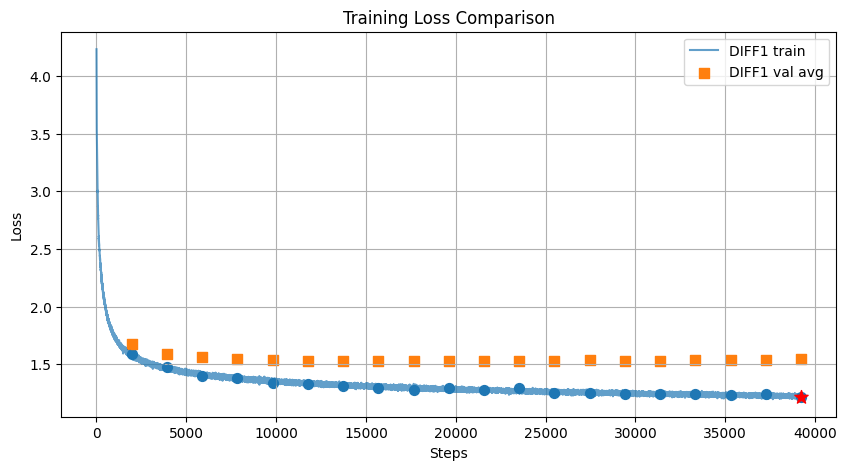

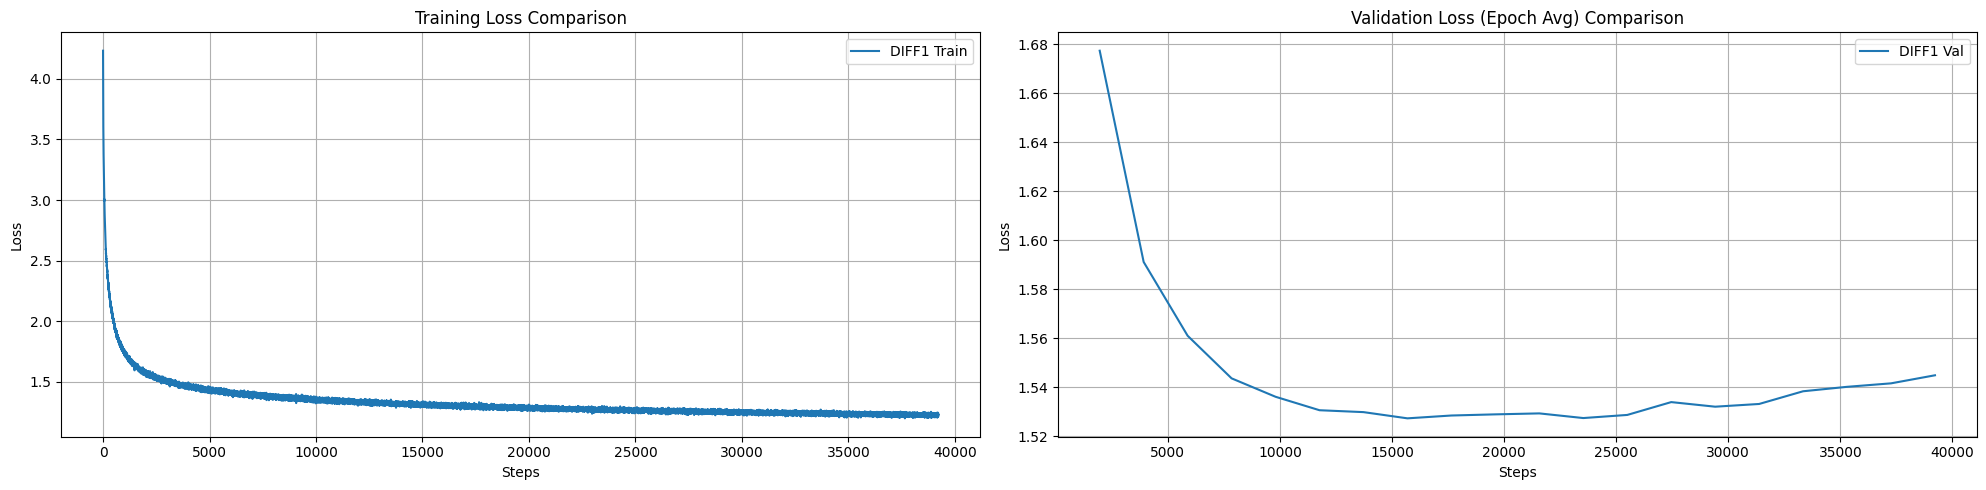

In [26]:
train_and_test("DIFF1", diff1)

## θ₂: 1000

In [27]:
THETA = 1000.0

In [28]:
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    FFN_DIM = FFN_DIM
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = THETA, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    # x: [B, L, n_kv, d]
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        self.w1 = nn.Linear(dim, ffn_dim, bias=False)
        self.w2 = nn.Linear(ffn_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, ffn_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class DiffSelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device, depth=0):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep  # typically n_heads // n_kv_heads
        self.head_dim = dim // n_heads  # standard head dimension


        self.wq = nn.Linear(dim, 2 * n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        # Output projection expects input dim = 2*n_heads*head_dim.
        self.wo = nn.Linear(2 * n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout

        # KV Cache (for inference with caching)
        self.cache_k = torch.zeros(batch, 2 * n_heads, seq_len, self.head_dim, device=device)
        self.cache_v = torch.zeros(batch, n_heads, seq_len, 2 * self.head_dim, device=device)

        # Lambda parameter as in diff attention paper.
        self.lambda_init = 0.8 - 0.6 * math.exp(-0.3 * depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        
        # groupnorm
        self.norm = RMSNorm(2*self.head_dim)

    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos # same with start_pos
        
        # Project and reshape: 
        xq = self.wq(x).view(B, trg_len, 2 * self.n_heads_q, self.head_dim)   # [B, L, 2*heads, head_dim]
        xk = self.wk(x).view(B, src_len, 2 * self.n_kv_heads, self.head_dim)  # [B, L, 2*heads_kv, head_dim]
        xv = self.wv(x).view(B, src_len, self.n_kv_heads, 2 * self.head_dim)  # [B, L, heads_kv, 2*head_dim]
        
        # Apply rotary embeddings on queries and keys.
        xq = apply_rotary_emb(xq, device=x.device)
        xk = apply_rotary_emb(xk, device=x.device)
        
        # Grouped Query Attention:
        xq = xq.transpose(1, 2)                         # [B, 2*heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        
        # Update KV cache.
        self.cache_k[:B, :, offset:offset+L] = xk
        self.cache_v[:B, :, offset:offset+L] = xv
        
        # scaling
        scaling = 1 / math.sqrt(self.head_dim)
        xq *= scaling
        
        attn_weights = torch.matmul(xq, xk.transpose(-1, -2))
        
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
        
        attn_weights = torch.nan_to_num(attn_weights)
        attn_weights += mask
        attn_weights = F.softmax(attn_weights, dim=-1).type_as(attn_weights)
        attn_weights = attn_weights.view(B, self.n_heads_q, 2, trg_len, src_len)
        
        # Combine the two attention scores with lambda.
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(xq)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(xq)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        
        attn1 = attn_weights[:,:,0]
        attn2 = attn_weights[:,:,1]
        
        attn_weights = attn1 - lambda_full * attn2
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        
        # Compute attention output.
        attn = torch.matmul(attn_weights, xv)
        attn = self.norm(attn)
        attn = attn * (1-self.lambda_init)
        attn = attn.transpose(1, 2).contiguous().view(B, L, -1)
        attn_output = self.wo(attn)
        
        if return_attn:
            # Return four maps:
            # [첫 번째 맵(attn1), 두 번째 맵(attn2), 두 번째 맵에 람다를 곱한 결과, 최종 결과(attn_weights)]
            return attn_output, [attn1, attn2, lambda_full*attn2, attn_weights]
        else:
            return attn_output

# Transformer Block.
class TransformerBlock(nn.Module):
    def __init__(self, args, depth: int = 0):
        super().__init__()
        self.attn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.attention = DiffSelfAttention(
            n_heads=args.NUM_HEADS,
            n_kv_heads=args.NUM_KV_HEADS if args.NUM_KV_HEADS is not None else args.NUM_HEADS,
            n_rep=args.NUM_KV_HEAD_REP,
            dim=args.DIM,
            dropout=args.DROPOUT,
            batch=args.MAX_BATCH_SIZE,
            seq_len=args.MAX_SEQ_LEN,
            device=args.DEVICE,
            depth=depth
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attn_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attn_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class DiffTransformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args, depth=i) for i in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE

    def forward(self, x: torch.Tensor, start_pos: int = 0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, DIM]
        mask = None
        if L > 1:
            mask = torch.triu(torch.full((L, L), float('-inf'), device=self.device), diagonal=1)
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [29]:
PARAMS = ModelArgs()
diff2 = DiffTransformer(PARAMS).to(device)
diff2

DiffTransformer(
  (tok_embeddings): Embedding(65, 128)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attn_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (attention): DiffSelfAttention(
        (wq): Linear(in_features=128, out_features=256, bias=False)
        (wk): Linear(in_features=128, out_features=256, bias=False)
        (wv): Linear(in_features=128, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=128, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=128, out_features=352, bias=False)
        (w2): Linear(in_features=352, out_features=128, bias=False)
        (w3): Linear(in_features=128, out_features=352, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=128, out_features=65, bias=False)
)

In [30]:
from torchinfo import summary

# Describe the model
summary(diff2.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
DiffTransformer                          [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 128]            8,320
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [512, 64, 128]            --
│    │    └─RMSNorm: 3-1                 [512, 64, 128]            128
│    │    └─DiffSelfAttention: 3-2       [512, 64, 128]            131,264
│    │    └─Dropout: 3-3                 [512, 64, 128]            --
│    │    └─RMSNorm: 3-4                 [512, 64, 128]            128
│    │    └─FeedForward: 3-5             [512, 64, 128]            135,168
│    │    └─Dropout: 3-6                 [512, 64, 128]            --
│    └─TransformerBlock: 2-2             [512, 64, 128]            --
│    │    └─RMSNorm: 3-7                 [512, 64, 128]            128
│    │    └─DiffSelfAttention: 3-8       [512, 64, 128]            13

Epoch 1/20, Train Loss: 1.5928, Val Loss: 1.8201, Epoch Time: 240.99s Average Vram Usage: 561.72MB


Epoch 2/20, Train Loss: 1.4784, Val Loss: 1.8032, Epoch Time: 240.46s Average Vram Usage: 561.72MB


Epoch 3/20, Train Loss: 1.4070, Val Loss: 1.7907, Epoch Time: 242.41s Average Vram Usage: 561.72MB


Epoch 4/20, Train Loss: 1.3695, Val Loss: 1.7766, Epoch Time: 241.24s Average Vram Usage: 561.72MB


Epoch 5/20, Train Loss: 1.3675, Val Loss: 1.7559, Epoch Time: 240.88s Average Vram Usage: 561.72MB


Epoch 6/20, Train Loss: 1.3444, Val Loss: 1.7603, Epoch Time: 194.96s Average Vram Usage: 561.72MB


Epoch 7/20, Train Loss: 1.3370, Val Loss: 1.7491, Epoch Time: 173.48s Average Vram Usage: 561.72MB


Epoch 8/20, Train Loss: 1.3170, Val Loss: 1.7433, Epoch Time: 175.15s Average Vram Usage: 561.72MB


Epoch 9/20, Train Loss: 1.2861, Val Loss: 1.7581, Epoch Time: 175.61s Average Vram Usage: 561.72MB


Epoch 10/20, Train Loss: 1.2773, Val Loss: 1.7668, Epoch Time: 178.28s Average Vram Usage: 561.72MB


Epoch 11/20, Train Loss: 1.2933, Val Loss: 1.7526, Epoch Time: 174.88s Average Vram Usage: 561.72MB


Epoch 12/20, Train Loss: 1.2703, Val Loss: 1.7611, Epoch Time: 107.37s Average Vram Usage: 561.72MB


Epoch 13/20, Train Loss: 1.2582, Val Loss: 1.7506, Epoch Time: 83.99s Average Vram Usage: 561.72MB


Epoch 14/20, Train Loss: 1.2613, Val Loss: 1.7605, Epoch Time: 83.84s Average Vram Usage: 561.72MB


Epoch 15/20, Train Loss: 1.2573, Val Loss: 1.7741, Epoch Time: 85.08s Average Vram Usage: 561.72MB


Epoch 16/20, Train Loss: 1.2358, Val Loss: 1.7694, Epoch Time: 85.00s Average Vram Usage: 561.72MB


Epoch 17/20, Train Loss: 1.2300, Val Loss: 1.7687, Epoch Time: 84.69s Average Vram Usage: 561.72MB


Epoch 18/20, Train Loss: 1.2374, Val Loss: 1.7623, Epoch Time: 86.35s Average Vram Usage: 561.72MB


Epoch 19/20, Train Loss: 1.2193, Val Loss: 1.7506, Epoch Time: 85.16s Average Vram Usage: 561.72MB


Epoch 20/20, Train Loss: 1.2315, Val Loss: 1.7563, Epoch Time: 85.48s Average Vram Usage: 561.72MB


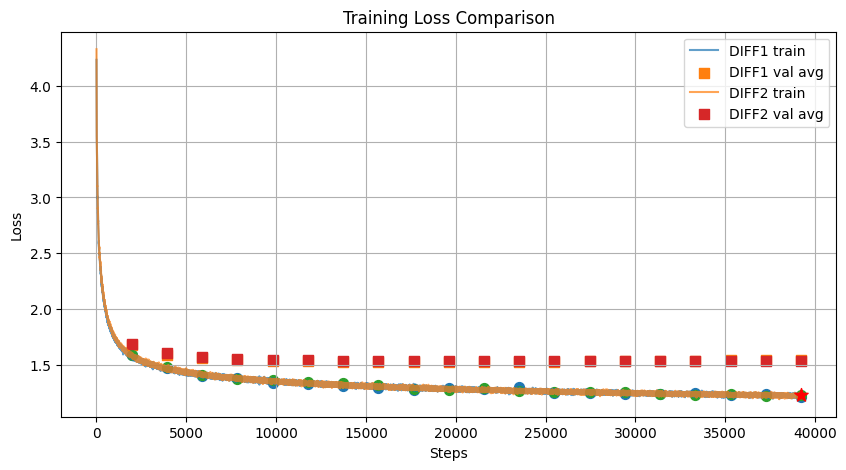

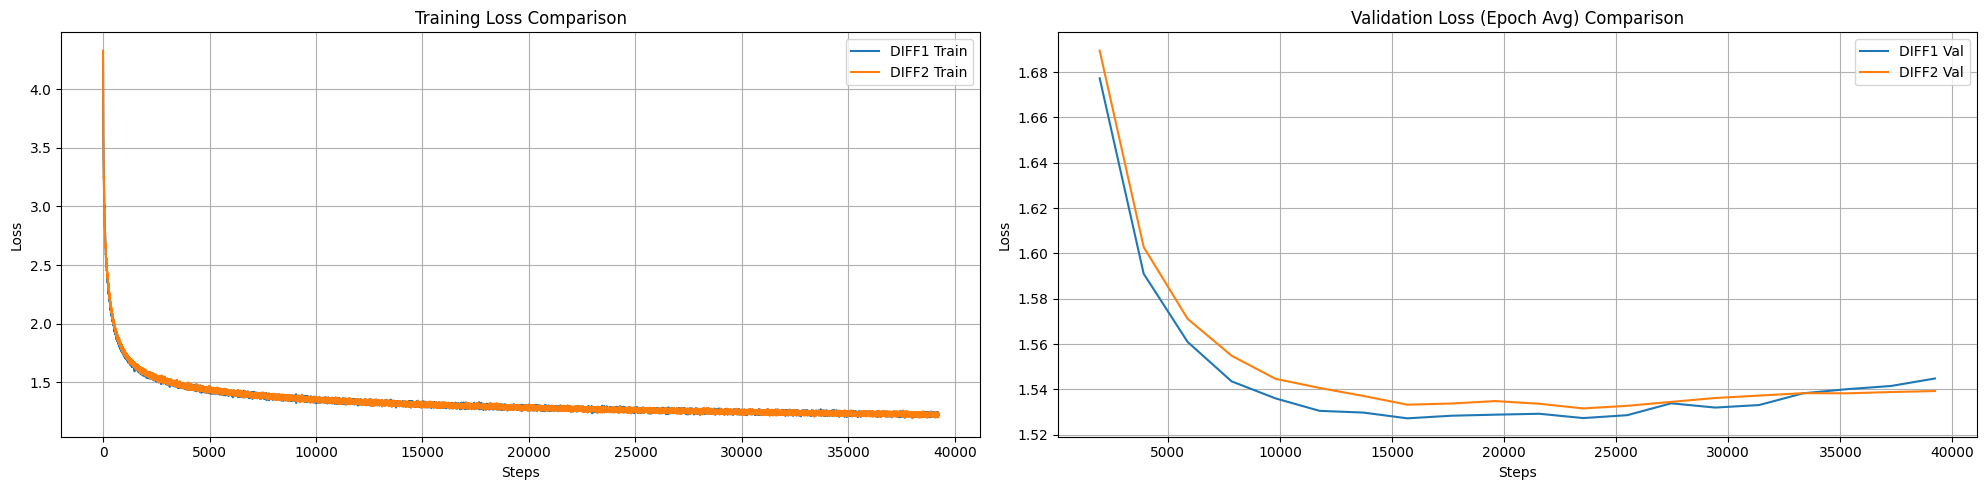

In [31]:
train_and_test("DIFF2", diff2)

## θ₃: 10000

In [32]:
THETA = 10000.0

In [33]:
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    FFN_DIM = FFN_DIM
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = THETA, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    # x: [B, L, n_kv, d]
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        self.w1 = nn.Linear(dim, ffn_dim, bias=False)
        self.w2 = nn.Linear(ffn_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, ffn_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class DiffSelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device, depth=0):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep  # typically n_heads // n_kv_heads
        self.head_dim = dim // n_heads  # standard head dimension


        self.wq = nn.Linear(dim, 2 * n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        # Output projection expects input dim = 2*n_heads*head_dim.
        self.wo = nn.Linear(2 * n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout

        # KV Cache (for inference with caching)
        self.cache_k = torch.zeros(batch, 2 * n_heads, seq_len, self.head_dim, device=device)
        self.cache_v = torch.zeros(batch, n_heads, seq_len, 2 * self.head_dim, device=device)

        # Lambda parameter as in diff attention paper.
        self.lambda_init = 0.8 - 0.6 * math.exp(-0.3 * depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        
        # groupnorm
        self.norm = RMSNorm(2*self.head_dim)

    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos # same with start_pos
        
        # Project and reshape: 
        xq = self.wq(x).view(B, trg_len, 2 * self.n_heads_q, self.head_dim)   # [B, L, 2*heads, head_dim]
        xk = self.wk(x).view(B, src_len, 2 * self.n_kv_heads, self.head_dim)  # [B, L, 2*heads_kv, head_dim]
        xv = self.wv(x).view(B, src_len, self.n_kv_heads, 2 * self.head_dim)  # [B, L, heads_kv, 2*head_dim]
        
        # Apply rotary embeddings on queries and keys.
        xq = apply_rotary_emb(xq, device=x.device)
        xk = apply_rotary_emb(xk, device=x.device)
        
        # Grouped Query Attention:
        xq = xq.transpose(1, 2)                         # [B, 2*heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        
        # Update KV cache.
        self.cache_k[:B, :, offset:offset+L] = xk
        self.cache_v[:B, :, offset:offset+L] = xv
        
        # scaling
        scaling = 1 / math.sqrt(self.head_dim)
        xq *= scaling
        
        attn_weights = torch.matmul(xq, xk.transpose(-1, -2))
        
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
        
        attn_weights = torch.nan_to_num(attn_weights)
        attn_weights += mask
        attn_weights = F.softmax(attn_weights, dim=-1).type_as(attn_weights)
        attn_weights = attn_weights.view(B, self.n_heads_q, 2, trg_len, src_len)
        
        # Combine the two attention scores with lambda.
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(xq)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(xq)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        
        attn1 = attn_weights[:,:,0]
        attn2 = attn_weights[:,:,1]
        
        attn_weights = attn1 - lambda_full * attn2
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        
        # Compute attention output.
        attn = torch.matmul(attn_weights, xv)
        attn = self.norm(attn)
        attn = attn * (1-self.lambda_init)
        attn = attn.transpose(1, 2).contiguous().view(B, L, -1)
        attn_output = self.wo(attn)
        
        if return_attn:
            # Return four maps:
            # [첫 번째 맵(attn1), 두 번째 맵(attn2), 두 번째 맵에 람다를 곱한 결과, 최종 결과(attn_weights)]
            return attn_output, [attn1, attn2, lambda_full*attn2, attn_weights]
        else:
            return attn_output

# Transformer Block.
class TransformerBlock(nn.Module):
    def __init__(self, args, depth: int = 0):
        super().__init__()
        self.attn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.attention = DiffSelfAttention(
            n_heads=args.NUM_HEADS,
            n_kv_heads=args.NUM_KV_HEADS if args.NUM_KV_HEADS is not None else args.NUM_HEADS,
            n_rep=args.NUM_KV_HEAD_REP,
            dim=args.DIM,
            dropout=args.DROPOUT,
            batch=args.MAX_BATCH_SIZE,
            seq_len=args.MAX_SEQ_LEN,
            device=args.DEVICE,
            depth=depth
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attn_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attn_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class DiffTransformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args, depth=i) for i in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE

    def forward(self, x: torch.Tensor, start_pos: int = 0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, DIM]
        mask = None
        if L > 1:
            mask = torch.triu(torch.full((L, L), float('-inf'), device=self.device), diagonal=1)
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [34]:
PARAMS = ModelArgs()
diff3 = DiffTransformer(PARAMS).to(device)
diff3

DiffTransformer(
  (tok_embeddings): Embedding(65, 128)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attn_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (attention): DiffSelfAttention(
        (wq): Linear(in_features=128, out_features=256, bias=False)
        (wk): Linear(in_features=128, out_features=256, bias=False)
        (wv): Linear(in_features=128, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=128, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=128, out_features=352, bias=False)
        (w2): Linear(in_features=352, out_features=128, bias=False)
        (w3): Linear(in_features=128, out_features=352, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=128, out_features=65, bias=False)
)

In [35]:
summary(diff3.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
DiffTransformer                          [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 128]            8,320
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [512, 64, 128]            --
│    │    └─RMSNorm: 3-1                 [512, 64, 128]            128
│    │    └─DiffSelfAttention: 3-2       [512, 64, 128]            131,264
│    │    └─Dropout: 3-3                 [512, 64, 128]            --
│    │    └─RMSNorm: 3-4                 [512, 64, 128]            128
│    │    └─FeedForward: 3-5             [512, 64, 128]            135,168
│    │    └─Dropout: 3-6                 [512, 64, 128]            --
│    └─TransformerBlock: 2-2             [512, 64, 128]            --
│    │    └─RMSNorm: 3-7                 [512, 64, 128]            128
│    │    └─DiffSelfAttention: 3-8       [512, 64, 128]            13

Epoch 1/20, Train Loss: 1.5844, Val Loss: 1.7950, Epoch Time: 86.20s Average Vram Usage: 826.00MB


Epoch 2/20, Train Loss: 1.4622, Val Loss: 1.7631, Epoch Time: 86.58s Average Vram Usage: 826.00MB


Epoch 3/20, Train Loss: 1.3928, Val Loss: 1.7495, Epoch Time: 85.69s Average Vram Usage: 826.00MB


Epoch 4/20, Train Loss: 1.3795, Val Loss: 1.7095, Epoch Time: 85.26s Average Vram Usage: 826.00MB


Epoch 5/20, Train Loss: 1.3700, Val Loss: 1.6964, Epoch Time: 87.33s Average Vram Usage: 826.00MB


Epoch 6/20, Train Loss: 1.3446, Val Loss: 1.6979, Epoch Time: 86.52s Average Vram Usage: 826.00MB


Epoch 7/20, Train Loss: 1.3223, Val Loss: 1.6902, Epoch Time: 87.10s Average Vram Usage: 826.00MB


Epoch 8/20, Train Loss: 1.3156, Val Loss: 1.7014, Epoch Time: 87.48s Average Vram Usage: 826.00MB


Epoch 9/20, Train Loss: 1.2906, Val Loss: 1.7032, Epoch Time: 88.30s Average Vram Usage: 826.00MB


Epoch 10/20, Train Loss: 1.2795, Val Loss: 1.7077, Epoch Time: 86.52s Average Vram Usage: 826.00MB


Epoch 11/20, Train Loss: 1.2793, Val Loss: 1.7165, Epoch Time: 88.64s Average Vram Usage: 826.00MB


Epoch 12/20, Train Loss: 1.2812, Val Loss: 1.6980, Epoch Time: 89.31s Average Vram Usage: 826.00MB


Epoch 13/20, Train Loss: 1.2689, Val Loss: 1.7073, Epoch Time: 88.56s Average Vram Usage: 826.00MB


Epoch 14/20, Train Loss: 1.2590, Val Loss: 1.7024, Epoch Time: 89.35s Average Vram Usage: 826.00MB


Epoch 15/20, Train Loss: 1.2309, Val Loss: 1.6968, Epoch Time: 90.53s Average Vram Usage: 826.00MB


Epoch 16/20, Train Loss: 1.2486, Val Loss: 1.6976, Epoch Time: 91.24s Average Vram Usage: 826.00MB


Epoch 17/20, Train Loss: 1.2349, Val Loss: 1.6876, Epoch Time: 90.45s Average Vram Usage: 826.00MB


Epoch 18/20, Train Loss: 1.2477, Val Loss: 1.7032, Epoch Time: 91.27s Average Vram Usage: 826.00MB


Epoch 19/20, Train Loss: 1.2176, Val Loss: 1.6802, Epoch Time: 92.41s Average Vram Usage: 826.00MB


Epoch 20/20, Train Loss: 1.2357, Val Loss: 1.7030, Epoch Time: 91.57s Average Vram Usage: 826.00MB


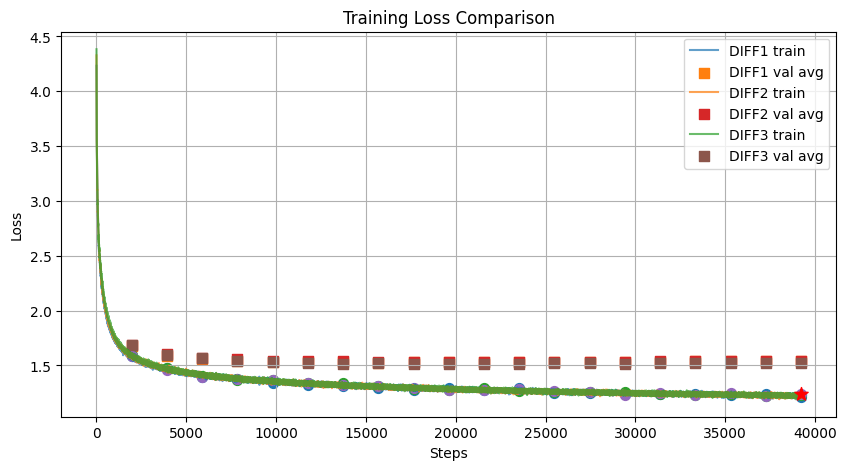

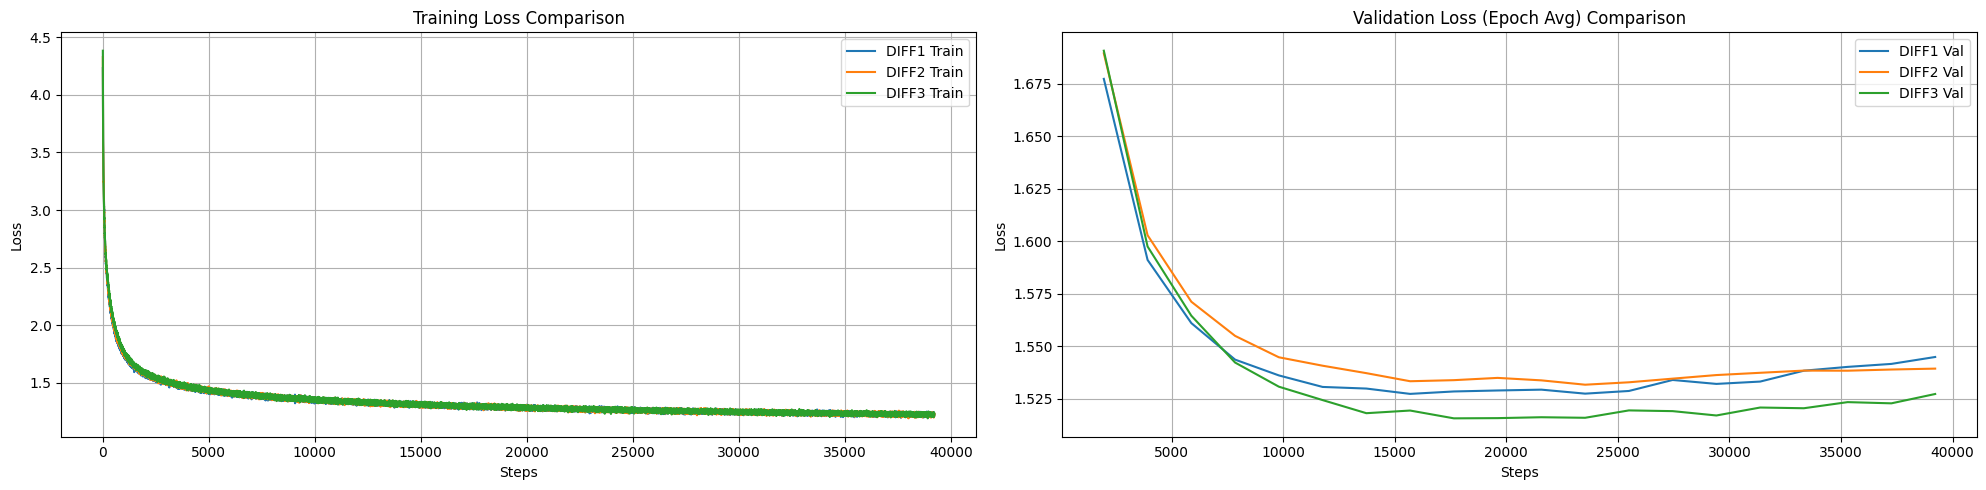

In [36]:
train_and_test("DIFF3", diff3)

## Compare Attention Map

In [37]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def compare_attention_maps(models_dict, dataloader, start_pos=0, layer=0, head=0):

    x, _ = next(iter(dataloader))
    device = 'cuda:0'
    x = x.to(device)
    
    attn_results = {}
    
    for name, model in models_dict.items():
        model = model.to(device)
        model.eval()
        with torch.inference_mode():
            _, attn_maps = model.forward(x, start_pos=start_pos, return_attn=True)
            attns = attn_maps[layer]         
            names = ['attn1', 'attn2', 'λ*attn2', 'attn1-λ*attn2']
            names = [name+'_'+x for x in names]
            for name, attn in zip(names, attns):
                attn_results[name] = attn[0, head].detach().cpu().numpy()
    
    n_models = len(attn_results)
    fig, axs = plt.subplots(1, n_models, figsize=(n_models * 4, 4))
    if n_models == 1:
        axs = [axs]

    for ax, (name, attn) in zip(axs, attn_results.items()):
        if 'attn1-λ*attn2' in name:
            im = ax.imshow(attn, interpolation='nearest', cmap='seismic', vmin=-1, vmax=1)
        else:
            im = ax.imshow(attn, interpolation='nearest', cmap='Reds', vmin=np.min(attn), vmax=np.max(attn))
        ax.set_title(f"{name.upper()} \nLayer {layer+1}, Head {head+1}")
        ax.set_xlabel("Key Token Position")
        ax.set_ylabel("Query Token Position")
        fig.colorbar(im, ax=ax)
        
    plt.tight_layout()
    plt.show()

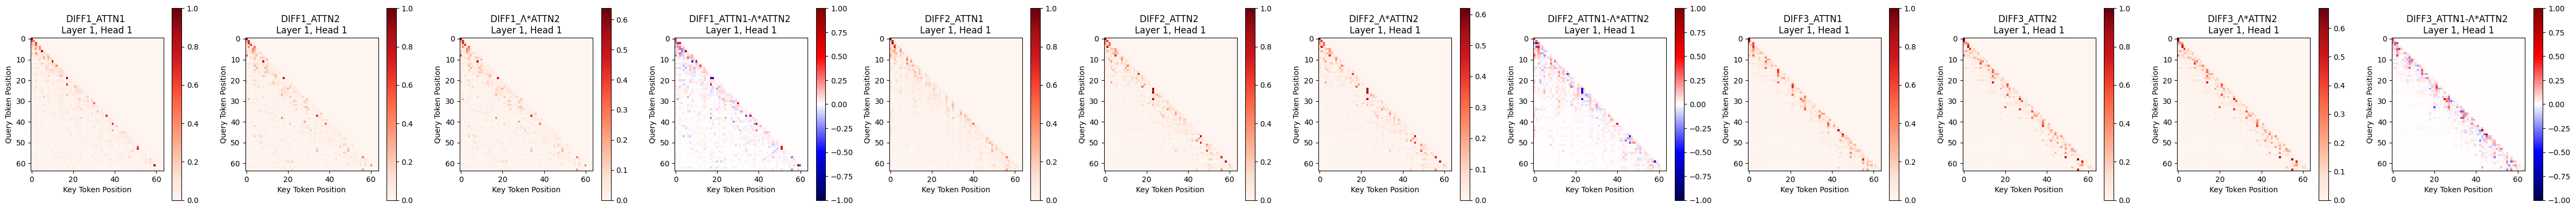

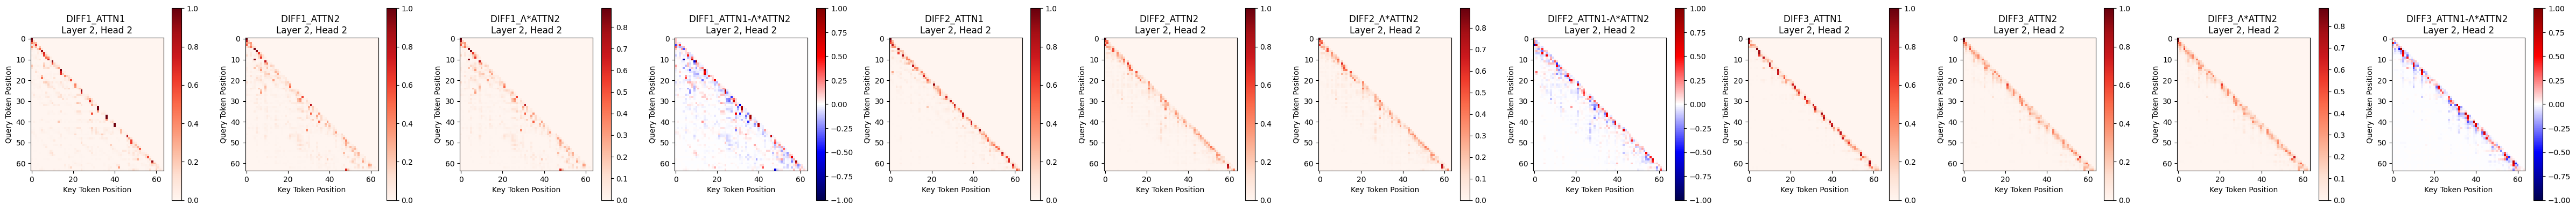

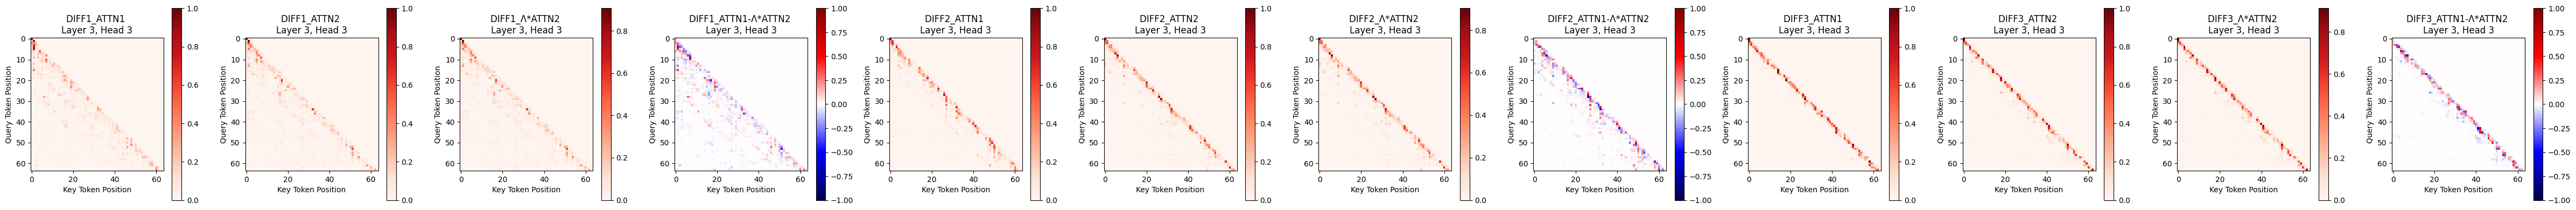

In [38]:
models = {
    "diff1": diff1,
    "diff2": diff2,
    "diff3": diff3,
}

for i in range(3):
    compare_attention_maps(models, train_loader, start_pos=0, layer=i, head=i)